In [22]:
# !pip install grape

In [23]:
from grape.datasets.kghub import KGIDG
import pandas as pd
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import PerceptronEdgePrediction
from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkSkipGramEnsmallen
from grape.embedders import WalkletsCBOWEnsmallen, WalkletsSkipGramEnsmallen
from grape.embedders import HOPEEnsmallen

In [24]:
g = KGIDG(version='20230601')
main_component = g.remove_components(top_k_components=1)
dense_main_component = main_component.remove_dendritic_trees()
drug_types = ["biolink:ChemicalSubstance", "biolink:ChemicalEntity", "biolink:Drug"]
protein_types = ["biolink:Protein"]
minority_edge_type = 'minority_edge'
dense_main_component.replace_edge_type_name_from_edge_node_type_names_inplace(
    edge_type_name=minority_edge_type,
    source_node_type_names=drug_types,
    destination_node_type_names=protein_types
)  
dense_main_component

<div class="graph-report"><style>.graph-report li {margin: 0.5em 0 0.5em 0;}.graph-report .paragraph {text-align: justify;word-break: break-all;}.graph-report .small-columns {column-count: 4;column-gap: 2em;}.graph-report .medium-columns {column-count: 3;column-gap: 2em;}.graph-report .large-columns {column-count: 2;column-gap: 2em;}.graph-report .single-column {}@media only screen and (max-width: 600px) {.graph-report .small-columns {column-count: 1;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 600px) and (max-width: 800px) {.graph-report .small-columns {column-count: 2;}.graph-report .medium-columns {column-count: 1;}.graph-report .large-columns {column-count: 1;}}@media only screen and (min-width: 800px) and (max-width: 1024px) {.graph-report .small-columns {column-count: 3;}.graph-report .medium-columns {column-count: 2;}.graph-report .large-columns {column-count: 1;}}</style><h2>KGIDG</h2><p class="paragraph">The undirected multigraph KGIDG has 239.46K heterogeneous nodes and 1.01M heterogeneous edges. The graph is connected, that is, it is composed of a single connected component that includes all nodes and edges. The RAM requirements for the nodes and edges data structures are 28.57MB and 9.97MB respectively.</p><h3 style="margin: 1em 0 0 0;">Degree centrality</h3><p class="paragraph">The minimum node degree is 2, the maximum node degree is 9.36K, the mode degree is 2, the mean degree is 8.41 and the node degree median is 4.</p><p class="paragraph">The nodes with the highest degree centrality are <a href='http://amigo.geneontology.org/amigo/term/GO:0065007' target='_blank' title='Go to Gene Ontology to get more informations about GO:0065007'>GO:0065007</a> (degree 9.36K and node types <a href='https://biolink.github.io/biolink-model/docs/BiologicalProcess.html' target='_blank' title='Go to BioLink to get more informations about biolink:BiologicalProcess'>biolink:BiologicalProcess</a> and <a href='https://biolink.github.io/biolink-model/docs/NamedThing.html' target='_blank' title='Go to BioLink to get more informations about biolink:NamedThing'>biolink:NamedThing</a>), <a href='https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:24995' target='_blank' title='Go to CHEBI to get more informations about CHEBI:24995'>CHEBI:24995</a> (degree 7.34K and node type <a href='https://biolink.github.io/biolink-model/docs/ChemicalSubstance.html' target='_blank' title='Go to BioLink to get more informations about biolink:ChemicalSubstance'>biolink:ChemicalSubstance</a>), <a href='https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:52898' target='_blank' title='Go to CHEBI to get more informations about CHEBI:52898'>CHEBI:52898</a> (degree 7.26K and node type <a href='https://biolink.github.io/biolink-model/docs/ChemicalSubstance.html' target='_blank' title='Go to BioLink to get more informations about biolink:ChemicalSubstance'>biolink:ChemicalSubstance</a>), <a href='https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:30616' target='_blank' title='Go to CHEBI to get more informations about CHEBI:30616'>CHEBI:30616</a> (degree 6.00K and node types <a href='https://biolink.github.io/biolink-model/docs/ChemicalSubstance.html' target='_blank' title='Go to BioLink to get more informations about biolink:ChemicalSubstance'>biolink:ChemicalSubstance</a> and <a href='https://biolink.github.io/biolink-model/docs/ChemicalEntity.html' target='_blank' title='Go to BioLink to get more informations about biolink:ChemicalEntity'>biolink:ChemicalEntity</a>) and <a href='https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:456216' target='_blank' title='Go to CHEBI to get more informations about CHEBI:456216'>CHEBI:456216</a> (degree 5.43K and node types <a href='https://biolink.github.io/biolink-model/docs/ChemicalSubstance.html' target='_blank' title='Go to BioLink to get more informations about biolink:ChemicalSubstance'>biolink:ChemicalSubstance</a> and <a

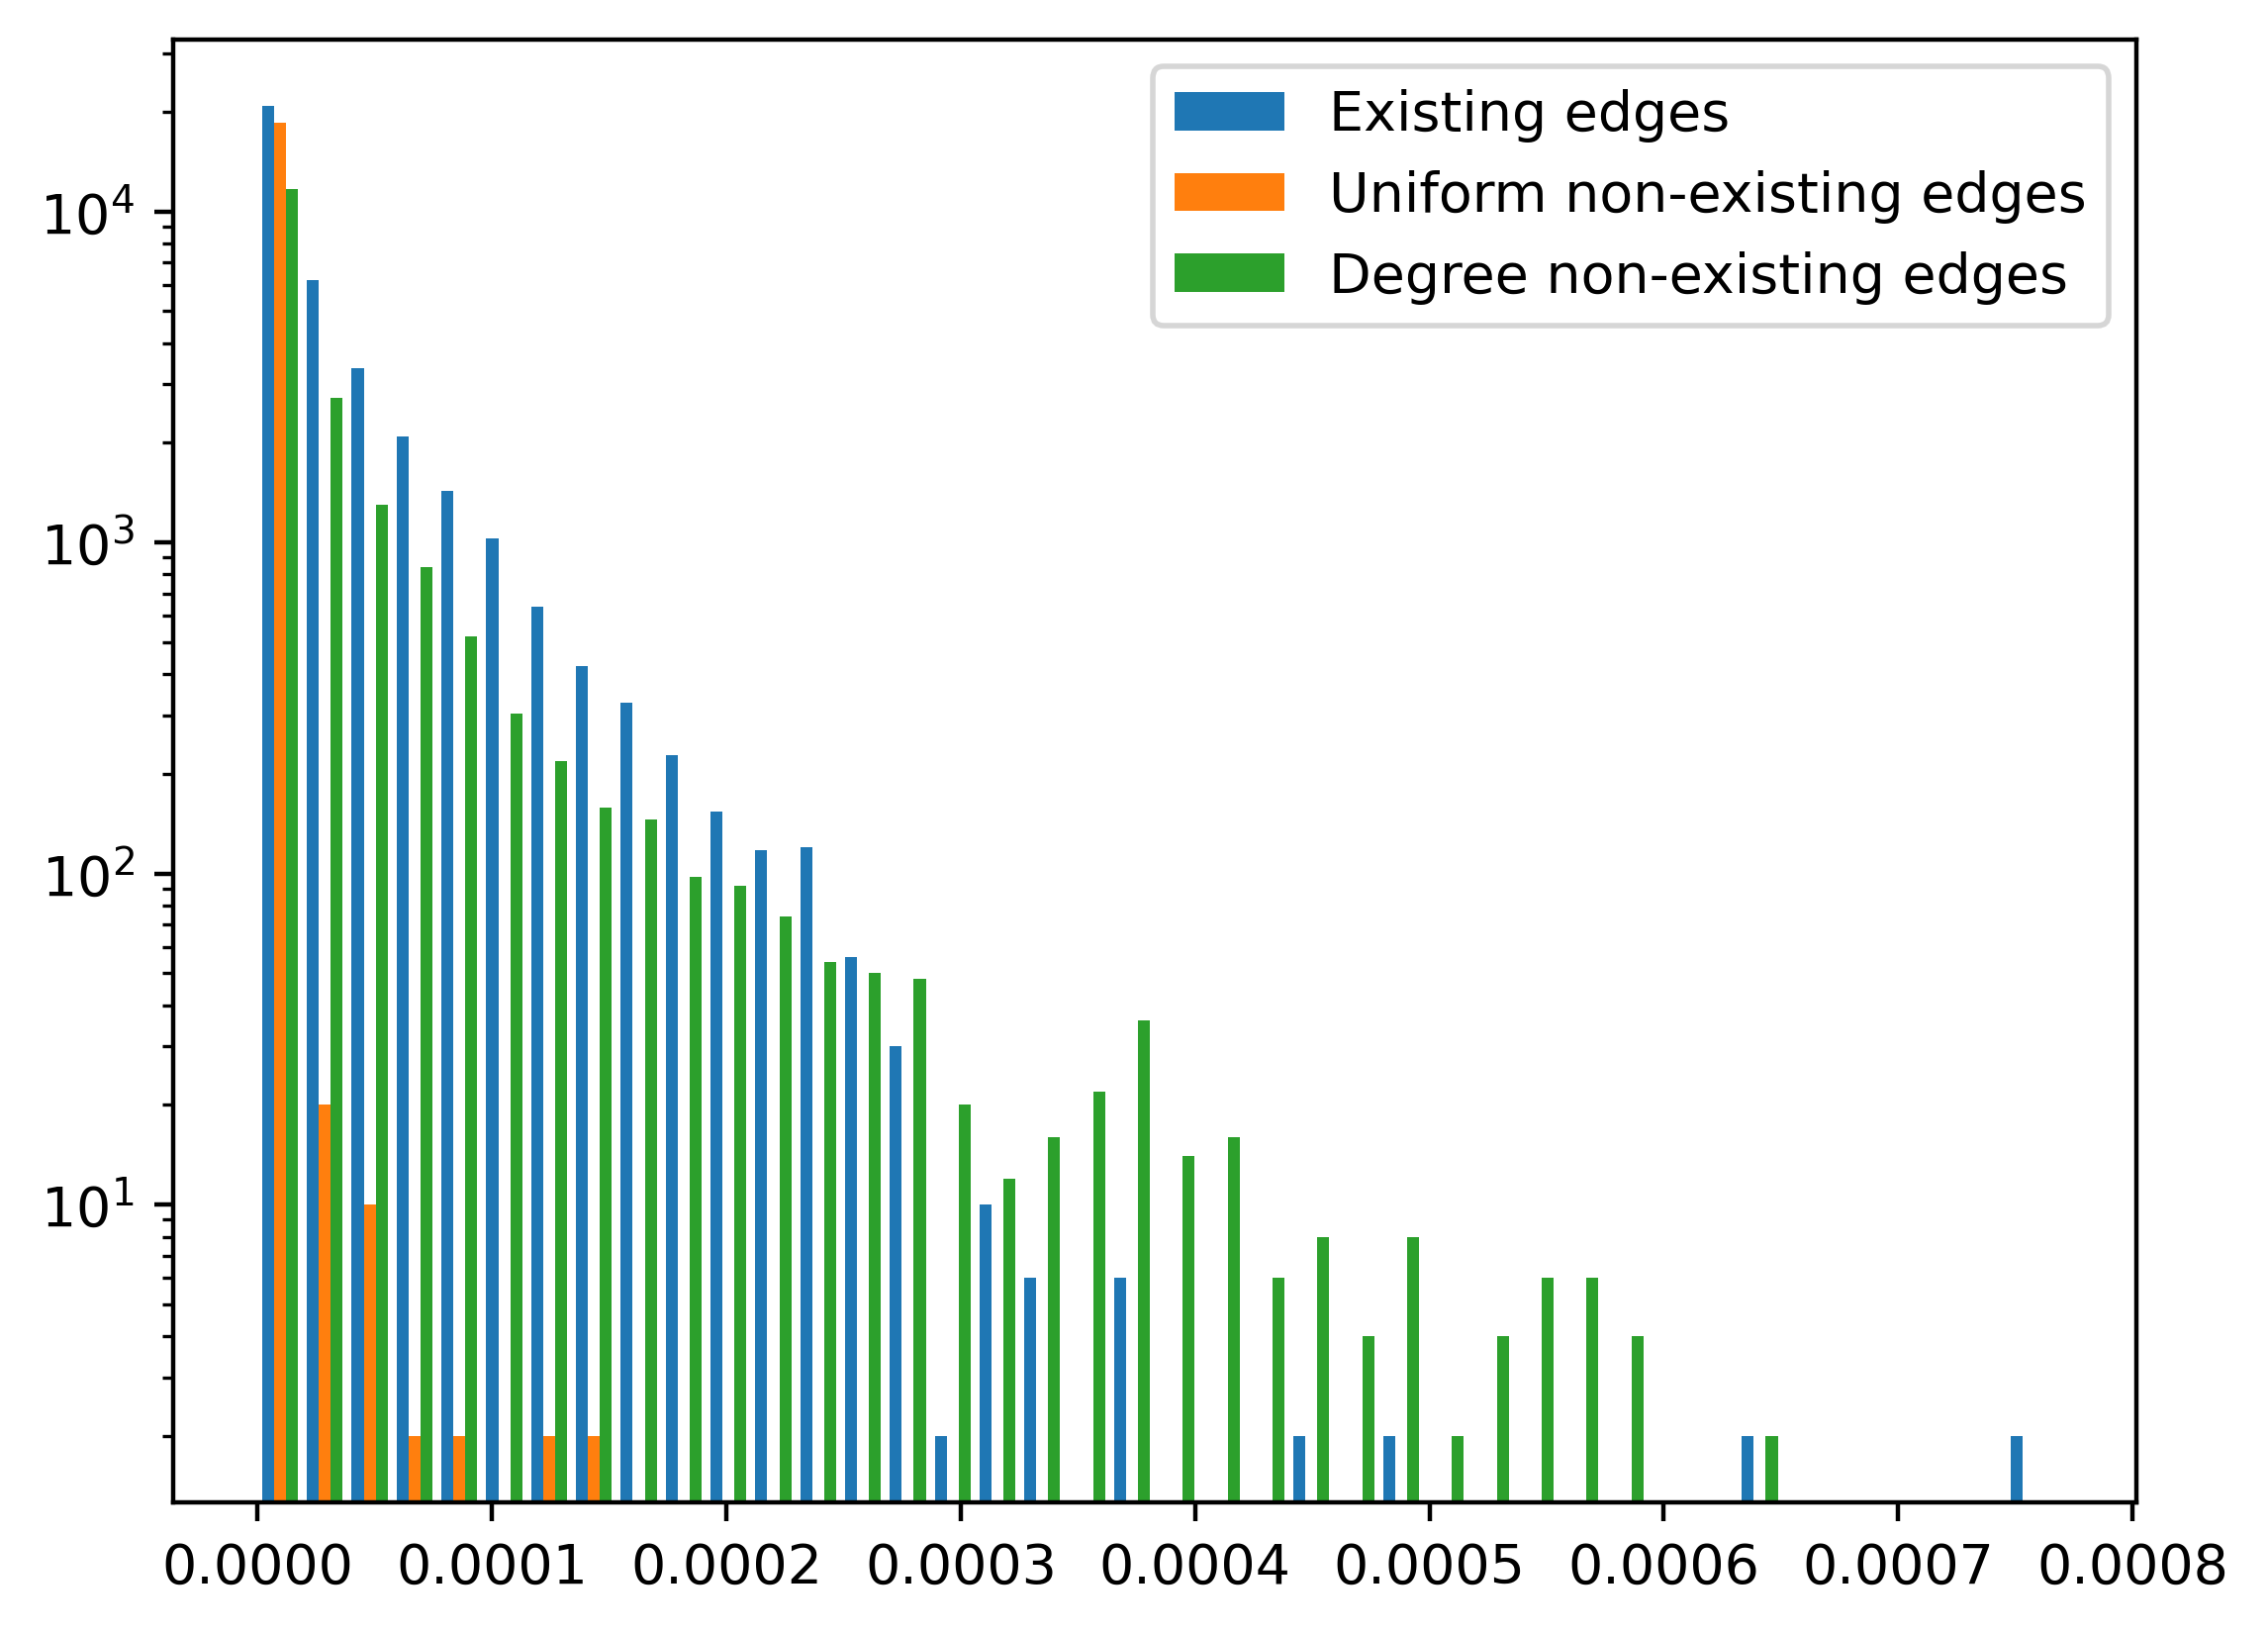

In [25]:
import matplotlib.pyplot as plt
import numpy as np

graph = dense_main_component.filter_from_names(edge_type_names_to_keep=[minority_edge_type])
composite_graph = dense_main_component

negative = graph.sample_negative_graph(
    number_of_negative_samples=graph.get_number_of_edges(),
    use_scale_free_distribution=False,
)

negative_scale_free = graph.sample_negative_graph(
    number_of_negative_samples=graph.get_number_of_edges(),
    use_scale_free_distribution=True,
)

existing_edges_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=graph
)
uniform_negative_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=negative
)
degree_negative_pa = composite_graph.get_preferential_attachment_scores(
    normalize=True,
    subgraph=negative_scale_free
)


fig, axes = plt.subplots(dpi=400)

plt.hist(
    [
        existing_edges_pa,
        uniform_negative_pa,
        degree_negative_pa
    ],
    log=True,
    bins=40,
    label=[
        "Existing edges",
        "Uniform non-existing edges",
        "Degree non-existing edges"
    ]
)
plt.legend()

In [26]:
# Set smoke test to True for testing:
# SMOKE_TEST = True
NUMBER_OF_HOLDOUTS = 10
VALIDATION_UNBALANCE_RATES = (1.0, )
TRAIN_SIZES = (0.75,)
subgraph = dense_main_component.filter_from_names(
    edge_type_names_to_keep=[minority_edge_type]
)
# Disable the smoke test when you need to run the real thing:
SMOKE_TEST = False
NUMBER_OF_HOLDOUTS = 10
VALIDATION_UNBALANCE_RATES = (1.0, )
TRAIN_SIZES = (0.75,)
results = []
for train_size in TRAIN_SIZES:
    for validation_use_scale_free in (True, False):
        for ModelClass in  [
                FirstOrderLINEEnsmallen,
                SecondOrderLINEEnsmallen,
                DeepWalkCBOWEnsmallen, DeepWalkSkipGramEnsmallen,
                WalkletsCBOWEnsmallen, WalkletsSkipGramEnsmallen,
                HOPEEnsmallen
            ]:
            # If the embedding method involves edge sampling, we train a run
            # using the scale free and one using the uniform.
            if "use_scale_free_distribution" in ModelClass().parameters():
                parameter_sets = [
                    # dict(
                    #     use_scale_free_distribution = True
                    # ),
                    dict(
                        use_scale_free_distribution = False
                    )
                ]
            else:
                parameter_sets = [dict()]
            print(f"train size: {train_size}; validation_use_scale_free: {validation_use_scale_free} ModelClass {ModelClass}")
            for parameter_set in parameter_sets:
                results.append(edge_prediction_evaluation(
                    smoke_test=SMOKE_TEST,
                    holdouts_kwargs=dict(
                        train_size=train_size,
                        edge_types=[minority_edge_type],
                    ),
                    evaluation_schema="Connected Monte Carlo",
                    node_features=ModelClass(**parameter_set),
                    graphs=dense_main_component,
                    models=[
                        PerceptronEdgePrediction(
                            edge_features=None,
                            edge_embeddings="Hadamard",
                            number_of_edges_per_mini_batch=32,
                            use_scale_free_distribution=use_scale_free_distribution
                        )
                        # for use_scale_free_distribution in (True, False)
                        for use_scale_free_distribution in [False]
                    ],
                    enable_cache=True,
                    number_of_holdouts=NUMBER_OF_HOLDOUTS,
                    use_scale_free_distribution=validation_use_scale_free,
                    validation_unbalance_rates=VALIDATION_UNBALANCE_RATES,
                    subgraph_of_interest=subgraph,
                    use_subgraph_as_support=False
                ))
results = pd.concat(results)
results.to_csv("kg_idg_negative_select.tsv",sep="\t")

train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.first_order_line.FirstOrderLINEEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.second_order_line.SecondOrderLINEEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.deepwalk_cbow.DeepWalkCBOWEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.deepwalk_skipgram.DeepWalkSkipGramEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.walklets_cbow.WalkletsCBOWEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmallen_embedders.walklets_skipgram.WalkletsSkipGramEnsmallen'>
train size: 0.75; validation_use_scale_free: True ModelClass <class 'embiggen.embedders.ensmalle

In [37]:
from glob import glob 
paths = glob("experiments/Ed*/KGIDG/*gz")
paths
import pandas as pd 
df = pd.concat([pd.read_csv(path, index_col=0) for path in paths]).reset_index(drop=True)
df.to_csv("dans_kg_idg_raw_data.csv")
gb = ['evaluation_mode', 'use_scale_free_distribution', 'features_names', "('model_parameters', 'use_scale_free_distribution')",  "('features_parameters', 'use_scale_free_distribution')"]
metrics = ['matthews_correlation_coefficient']
df = df[df["('model_parameters', 'use_scale_free_distribution')"] == False]
df[df["features_names"] == "HOPE"]

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,fall_out,prevalence,negative_likelyhood_ratio,f1_score,fowlkes_mallows_index,precision,...,"('features_parameters', 'use_scale_free_distribution')","('features_parameters', 'dtype')","('features_parameters', 'verbose')","('features_parameters', 'avoid_false_negatives')","('features_parameters', 'node_embedding_path')","('features_parameters', 'return_weight')","('features_parameters', 'explore_weight')","('features_parameters', 'contextual_node_embedding_path')","('features_parameters', 'metric')","('features_parameters', 'root_node_name')"
460,train,0.013806,1.0,False,0.001438,0.666667,0.099957,0.947114,0.948403,0.999202,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
461,test,0.013806,1.0,False,0.000431,0.666667,0.151921,0.917727,0.920831,0.999746,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
462,train,0.013806,1.0,False,0.001151,0.666667,0.099784,0.947265,0.948555,0.999361,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
463,test,0.013806,1.0,False,0.000431,0.666667,0.153647,0.916715,0.919893,0.999745,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
464,train,0.013806,1.0,False,0.000575,0.666667,0.102533,0.945853,0.947227,0.999680,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
465,test,0.013806,1.0,False,0.000431,0.666667,0.151489,0.917979,0.921065,0.999746,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
466,train,0.013806,1.0,False,0.001438,0.666667,0.101973,0.945997,0.947341,0.999200,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
467,test,0.013806,1.0,False,0.000863,0.666667,0.151339,0.917998,0.921065,0.999492,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
468,train,0.013806,1.0,False,0.000719,0.666667,0.101828,0.946216,0.947568,0.999600,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN
469,test,0.013806,1.0,False,0.000000,0.666667,0.155953,0.915429,0.918720,1.000000,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,Neighbours Intersection size,NaN


In [61]:
from glob import glob 
paths = glob("experiments/Ed*/KGIDG/*gz")
paths
import pandas as pd 
df = pd.concat([pd.read_csv(path, index_col=0) for path in paths]).reset_index(drop=True)
df.to_csv("dans_kg_idg_raw_data.csv")
gb = ['evaluation_mode', 'use_scale_free_distribution', 'features_names', 
      # "('model_parameters', 'use_scale_free_distribution')",  "('features_parameters', 'use_scale_free_distribution')"]
     ]
metrics = ['matthews_correlation_coefficient']
df = df[df["('model_parameters', 'use_scale_free_distribution')"] == False]
df = df[(df["('features_parameters', 'use_scale_free_distribution')"] == False) | (df['features_names'] == 'HOPE')]

sf_df = df[[*gb, *metrics]].groupby(gb).agg(['mean', 'std'])
sf_df.to_csv("dans_kg_idg_data.csv")
sf_df
data = sf_df
data = data.reset_index()
data

evaluation_mode use_scale_free_distribution     features_names  \
                                                                    
0             test                       False      DeepWalk CBOW   
1             test                       False  DeepWalk SkipGram   
2             test                       False   First-order LINE   
3             test                       False               HOPE   
4             test                       False  Second-order LINE   
5             test                       False      Walklets CBOW   
6             test                       False  Walklets SkipGram   
7             test                        True      DeepWalk CBOW   
8             test                        True  DeepWalk SkipGram   
9             test                        True   First-order LINE   
10            test                        True               HOPE   
11            test                        True  Second-order LINE   
12            test                        True      Walklets CBOW   
13            test                        True  Walklets SkipGram   
14           train                       False      DeepWalk CBOW   
15           train                       False  DeepWalk SkipGram   
16           train                       False   First-order LINE   
17           train                       False               HOPE   
18           train                       False  Second-order LINE   
19           train                       False      Walklets CBOW   
20           train                       False  Walklets SkipGram   
21           train                        True      DeepWalk CBOW   
22           train                        True  DeepWalk SkipGram   
23           train                        True   First-order LINE   
24           train                        True               HOPE   
25           train                        True  Second-order LINE   
26           train                        True      Walklets CBOW   
27           train                        True  Walklets SkipGram   

   matthews_correlation_coefficient            
                               mean       std  
0                          0.833450  0.014323  
1                          0.896665  0.006794  
2                          0.911075  0.003534  
3                          0.805258  0.002886  
4                          0.915201  0.004483  
5                          0.921473  0.009204  
6                          0.887040  0.012773  
7                          0.411648  0.018964  
8                          0.171205  0.050985  
9                         -0.056651  0.008033  
10                        -0.018332  0.008330  
11                         0.010862  0.023942  
12                         0.167737  0.023917  
13                         0.228533  0.033768  
14                         0.999353  0.000233  
15                         0.996195  0.001396  
16                         0.988345  0.000667  
17                         0.863336  0.001329  
18                         0.983922  0.001020  
19                         0.996420  0.001500  
20                         0.996247  0.001140  
21                         0.635713  0.023429  
22                         0.361237  0.047918  
23                         0.109259  0.006450  
24                         0.048594  0.005617  
25                         0.160474  0.024970  
26                         0.316738  0.022082  
27                         0.411973  0.032111

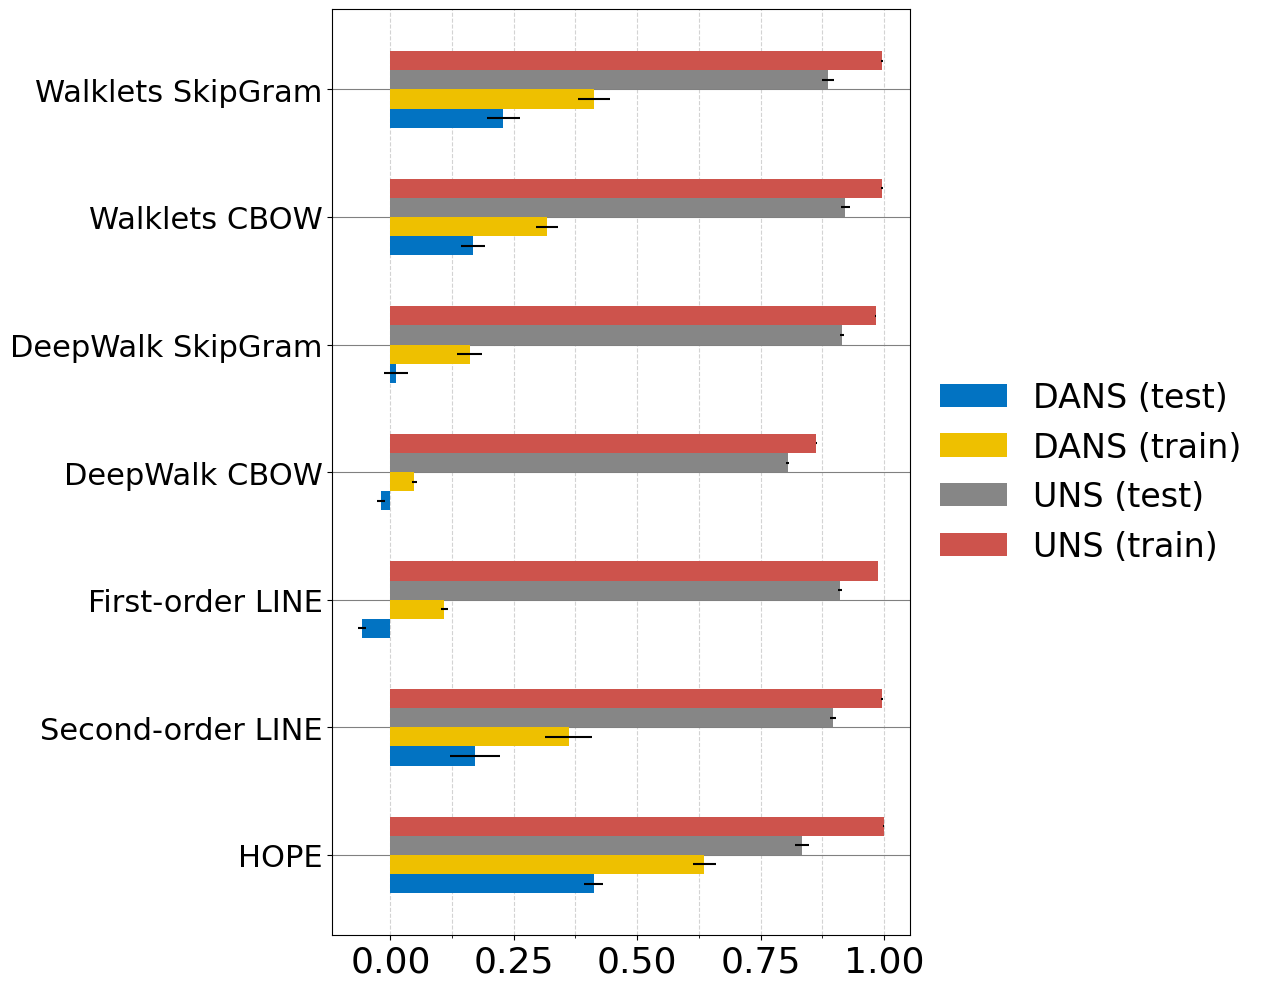

In [78]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Custom colors for the plot
colors = {
    'False_False': '#868686',  # UNS (Test) - grey
    'False_True': '#cd534c',   # UNS (Train) - red
    'True_False': '#0273c2',   # DANS (Test) - blue
    'True_True': '#eec000'     # DANS (Train) - yellow
}

# Specified order of features
features_order = [
    'Walklets SkipGram',
    'Walklets CBOW',
    'DeepWalk SkipGram',
    'DeepWalk CBOW',
    'First-order LINE',
    'Second-order LINE',
    'HOPE'
]

# Reorder the DataFrame
data['features_names'] = pd.Categorical(data['features_names'], categories=features_order, ordered=True)
# data.sort_values('features_names', ascending=False, inplace=True)
data

# Creating figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

bar_height = 0.15
index = np.arange(len(data['features_names'].unique()))
for i, (scale_free, mode) in enumerate([(True, False), (True, True), (False, False), (False, True)]):
    subset = data[(data['use_scale_free_distribution'] == scale_free) & (data['evaluation_mode'] == ('test' if mode == False else 'train'))]
    if not subset.empty:
        ax.barh(index + i * bar_height,
                subset[('matthews_correlation_coefficient', 'mean')],
                bar_height,
                xerr=subset[('matthews_correlation_coefficient', 'std')],
                color=colors[f'{scale_free}_{mode}'],
                label='UNS (test)' if scale_free == False and mode == False else (
                      'UNS (train)' if scale_free == False and mode == True else (
                      'DANS (test)' if scale_free == True and mode == False else 'DANS (train)')))

# Add vertical grid lines at increments of 0.125
ax.set_xticks(np.arange(0, 1.01, 0.125), minor=True)
ax.grid(which='minor', axis='x', linestyle='--', color='#d3d3d3')
ax.grid(which='major', axis='x', linestyle='--', color='#d3d3d3')
ax.yaxis.grid(True, linestyle='-', color='gray')
ax.set_axisbelow(True)

ax.set_xlabel('')
ax.set_yticks(index + bar_height * 1.5)
ax.set_yticklabels(features_order[::-1])
ax.set_xticks(np.arange(0, 1.01, 0.25))
ax.tick_params(axis='x', labelsize=26)
ax.tick_params(axis='y', labelsize=22)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=24)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('kg_idg_dans.png', bbox_inches='tight')
plt.show()